# Figure 6: view 9 examples of same hemorrhage with different kV and mA combinations.

   Unnamed: 0      case  truth      pred type    volume  intensity
0           0  case_000      1  0.942814  IPH  5.691528  60.908037
1           1  case_001      1  0.966938  IPH  5.691528  60.908037
2           2  case_002      1  0.895567  IPH  5.691528  60.908037
3           3  case_003      1  0.927125  IPH  5.691767  60.908037
4           4  case_004      1  0.909161  IPH  5.691528  60.908037
5           5  case_005      1  0.916811  IPH  5.691767  60.908037
6           6  case_006      1  0.893378  IPH  5.691767  60.908037
7           7  case_007      1  0.939426  IPH  5.691767  60.908037
8           8  case_008      1  0.901578  IPH  5.691767  60.908037


/tmp/ipykernel_125340/2949399098.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


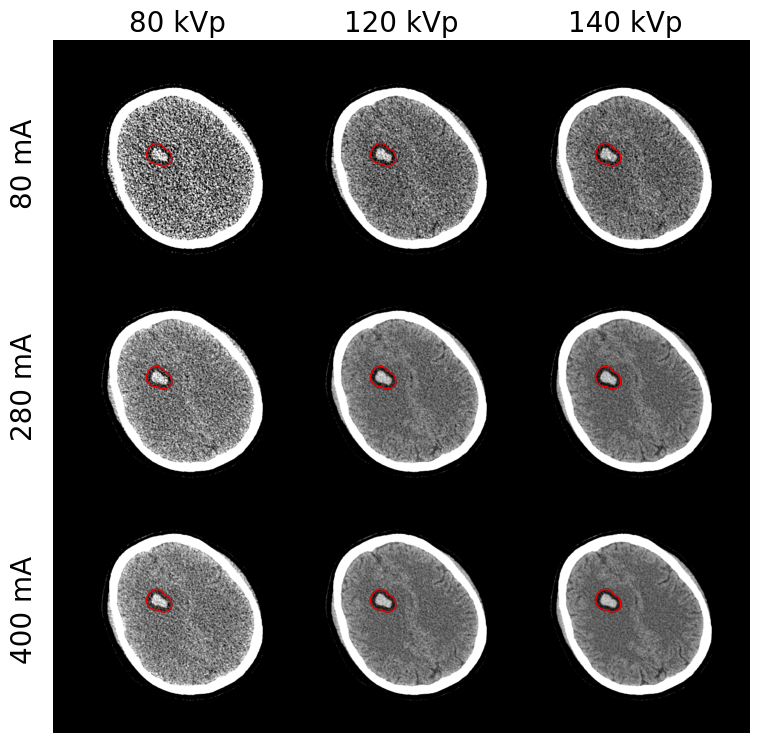

In [1]:
import os
from image_utils import download_and_extract_archive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pydicom
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()

def read_dicom(img_path):
    dcm = pydicom.dcmread(img_path)
    return dcm.pixel_array + int(dcm.RescaleIntercept)


study_name = os.getenv('EXPERIMENT_NAME')
base_dir = Path(os.getenv('BASE_DIR')) / study_name

metadata_filename = base_dir / (study_name + '_metadata.csv')
if not metadata_filename.exists():
    url = 'https://zenodo.org/records/15602167/files/kVp_mA_variation.zip'
    print(f"Dataset not detected\nDownloading {study_name} from {url}\nTo {base_dir}...")
    download_and_extract_archive(url, base_dir.parent, remove_finished=True)

results_df = pd.read_csv(str(base_dir / study_name) +  '_results.csv')

metadata_df = pd.read_csv(metadata_filename)
metadata_df['image file'] = metadata_df['image file'].apply(lambda o: str(base_dir) + '/' + o.split(study_name)[-1])
metadata_df['mask file'] = metadata_df['mask file'].apply(lambda o: str(base_dir) + '/' + o.split(study_name)[-1])

print(results_df)

cases = [item for item in sorted(os.listdir(base_dir)) if '.csv' not in item]
df = pd.read_csv(str(base_dir / study_name) + '.csv')
df['output_directory'] = base_dir

rows = 3
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, gridspec_kw=dict(wspace=-0.1, hspace=-0.1), figsize=(3*cols, 3*rows))
axs = axes.flat
for ax, patient in zip(axs, cases):
    model_pred = round(results_df[results_df['case'] == patient]['pred'].item(), 4)
    patient = str(patient).zfill(3)

    # find slice with biggest hemorrhage mask and load dicom
    case_metadata = metadata_df[metadata_df['name'] == patient]
    vol_max_idx = case_metadata['lesion volume [mL]'].idxmax()

    img_path = case_metadata['image file'][vol_max_idx]
    mask_path = case_metadata['mask file'][vol_max_idx]

    img = read_dicom(img_path)

    mask = read_dicom(mask_path)
    mask = np.where(mask > 0, 1, 0) # binarize mask
    
    labels, num = ski.measure.label(mask, background=0, connectivity=1, return_num=True)
    assert( labels.max() != 0 )
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    mask = ski.segmentation.find_boundaries(largestCC.astype('bool'), mode='thick', background=0)
    mask = ski.segmentation.find_boundaries(mask.astype('bool'), mode='thick', background=0)
    alpha = 1.0
    cmap='bwr_r'

    # plot
    #mask = ski.morphology.opening(mask, np.ones(2*[5]))
    new_mask = np.ma.masked_where(mask == False, mask)
    ax.imshow(img, vmin=0, vmax=80, cmap='gray') # show img
    ax.imshow(new_mask, cmap=cmap, alpha=alpha)

    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Hide ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # Hide tick labels for x-axis
    ax.set_xticklabels([])
    ax.set_yticklabels([])

cols_text = ['80 kVp', '120 kVp' , '140 kVp']
rows_text = ['80 mA', '280 mA', '400 mA']

for ax, col in zip(axes[0], cols_text):
    ax.set_title(col, size=20)

for ax, row in zip(axes[:, 0], rows_text):
    ax.set_ylabel(row, rotation=90, size=20)
    
fig.tight_layout()

plt.savefig('../manuscript_figures/Figure6.png', format='png', dpi=600)